<a href="https://colab.research.google.com/github/Yadukrishnan1/Fellow-Placement/blob/main/customer_success_ongoing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Succes Analysis for a Career Accelerator (Startup stage)**

---

An **online career accelerator** operates by helping prospective job seekers succesfully obtain a job in their industry role of choice. It is important for their business to determine if a new addition to their customers base could generate revenue by getting placed at the end of their service. This is also important to add reputation and to market their success.







1.  **Business Question**

What are the characteristic of a succesful(revenue generating) fellow (customer). How long do they take to guarantee the revenue (Time to get placed)?

2. **DS/ML Framing**

The first part of the question is a binary classification with two classes; 'placed' and 'not placed'. The second question is a regression problem.



# Importing all the required packages in Python

In [3]:
# Packages for EDA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
import time
import pickle

# Scikit-learn for ML prediction and modelling

from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from mpl_toolkits import mplot3d
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, RandomizedSearchCV

from xgboost.sklearn import XGBRegressor, XGBClassifier
import xgboost as xgb

from os import path

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Helper Functions
#----------------------------------------------------------------------
# Function to quickly describe a pandas dataframe 
#----------------------------------------------------------------------

class Quick_desc:
    def __init__(self, data):
        self.data = data
        
    def desc_data(self):
      print("\033[1m" + "Dataframe Shape - " + "\033[0m", end="")
      print((self.data).shape,'\n')
      print("\033[1m" + "Column names" + "\033[0m\n")
      print((self.data).columns, '\n')
      print("\033[1m" + "Missing Value Count" + "\033[0m\n")
      print((self.data).isnull().sum(),'\n')
      return (self.data).describe()

#----------------------------------------------------------------------
# Function to drop categorical NA from data
#----------------------------------------------------------------------
class Drop_cat_na:
  def __init__(self, data):
        self.data = data

  def drop_dat(self):
    for i in (self.data).select_dtypes(include=['object']).columns:
      self.data = self.data[self.data[i].notna()]
    return self.data

#----------------------------------------------------------------------
# Function to numerically encode categorical variables
#----------------------------------------------------------------------
class Cat_encode:
  def __init__(self, data):
        self.data = data

  def cat_encode(self):
    cat_df = (self.data).select_dtypes(include=['object']).copy()
    enc_make = OrdinalEncoder()
    cat_df_transformed = enc_make.fit_transform(cat_df)
    for i,j in enumerate(cat_df.columns):
      cat_df[j] = cat_df_transformed.transpose()[i]
    for i in df.columns:
      if i in cat_df.columns:
        self.data[i] = cat_df[i]
    return self.data

#----------------------------------------------------------------------
# Function to impute the missing values to a string value "NA"
#----------------------------------------------------------------------
class Imput_cat_na:
  def __init__(self, data):
        self.data = data

  def imput_dat(self):
    for i in (self.data).select_dtypes(include=['object']).columns:
      self.data[i].fillna("NA", inplace = True)
    return self.data

#----------------------------------------------------------------------
# Function to Plot the values
#----------------------------------------------------------------------
class Plot:
    def __init__(self, data):
        self.data = data
    
    def corr(self):
      fig, axes = plt.subplots(1, 1, figsize=(15,10))
      # Sub-sample dataframe
      sub_sample_corr = (self.data).corr()
      sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=axes)
      axes.set_title('Sub-sample Correlation Matrix', fontsize=14)
      plt.show()


In [126]:
# Loading the data
cust_success=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Pathrise/Data_Pathrise.xlsx')

# Exploratory Data Analysis

What are the variables (features) in our dataset? Which are the Predictor Variables and which is the Target Variables?

TV: 'placed'

PV: All others

Categorical variables such as 'program_duration_days', 'professional_experience', 'length_of_job_search' are ordinal attributes. All the rest of the categorical features are nominal attributes. One-hot-encoding is to be carried out for all the nominal attributes.

The testing set is selected by using the 'cust_success status' which are either 'Active' or 'Break'. The training set will be the Pathrise data without the testing set. A validation set should be made by doing a split of the training dataset.

Analysis should be two steps:

1) Determine what are the characteristics of fellows being placed. For that eliminate the 'program_duration_days' columns. Then see which columns contributes to it.

2) After determining the fellows, who get placed, use regression to see how long do they take to get placed.



In [127]:
cust_success.head()

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American


In [128]:
desc=Quick_desc(cust_success)
desc.desc_data()

Dataframe Shape - (2544, 16) 

Column names

Index(['id', 'pathrise_status', 'primary_track', 'cohort_tag',
       'program_duration_days', 'placed', 'employment_status ',
       'highest_level_of_education', 'length_of_job_search',
       'biggest_challenge_in_search', 'professional_experience',
       'work_authorization_status', 'number_of_interviews',
       'number_of_applications', 'gender', 'race'],
      dtype='object') 

Missing Value Count

id                               0
pathrise_status                  0
primary_track                    0
cohort_tag                       8
program_duration_days          616
placed                           0
employment_status              229
highest_level_of_education      58
length_of_job_search            74
biggest_challenge_in_search     24
professional_experience        222
work_authorization_status      284
number_of_interviews           218
number_of_applications           0
gender                         492
race                

,id,program_duration_days,placed,number_of_interviews,number_of_applications
count,2544.000000,1928.000000,2544.000000,2326.000000,2544.000000
mean,1272.500000,136.098548,0.375786,2.182287,36.500786
std,734.533866,125.860248,0.484420,2.959273,53.654896
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,636.750000,14.000000,0.000000,0.000000,9.000000
50%,1272.500000,112.000000,0.000000,1.000000,20.000000
75%,1908.250000,224.000000,1.000000,3.000000,45.000000
max,2544.000000,548.000000,1.000000,20.000000,1000.000000


## Data Visualizations

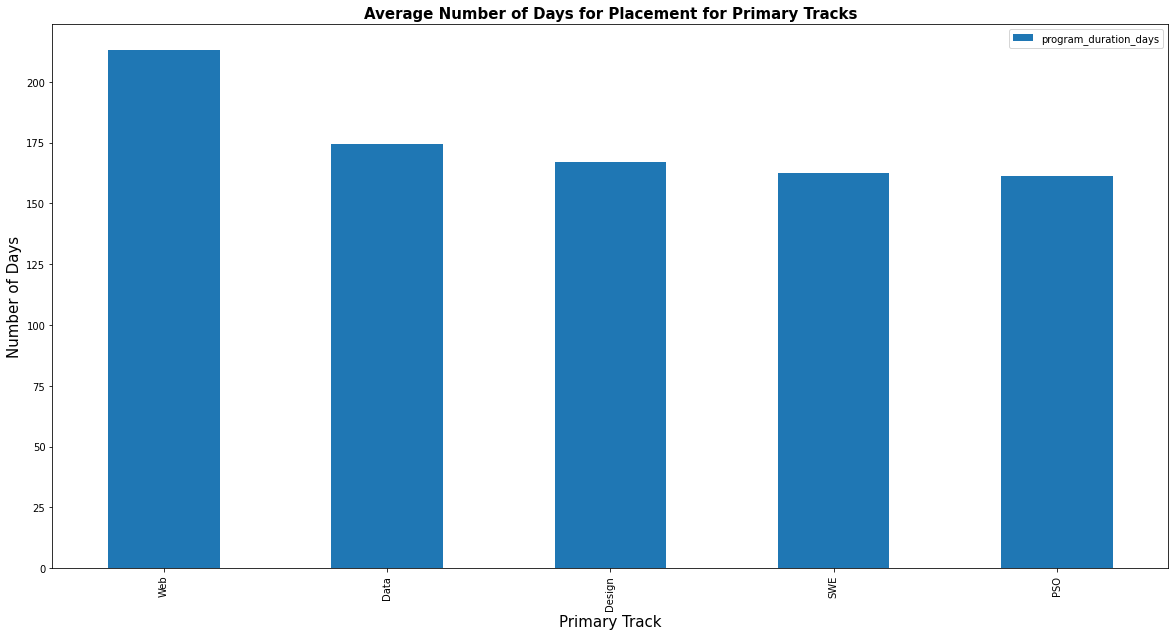

In [53]:
# Let's check the comparison for the "Average Number of Days for Placement" features as a function of the "tracks".
# Let's also keep cust_success as the original dataframe for a reference and use a generic name such as df for all the treatments.
df=cust_success

df_1 = df[df['placed'] == 1]
df_1.groupby('primary_track').agg({'program_duration_days':'mean'}).sort_values(by='program_duration_days', ascending=False).plot(kind='bar', figsize=(20,10))
plt.title ('Average Number of Days for Placement for Primary Tracks', fontsize=15, fontweight="bold")
plt.xlabel("Primary Track", fontsize=15)
plt.ylabel("Number of Days", fontsize=15)
plt.show()


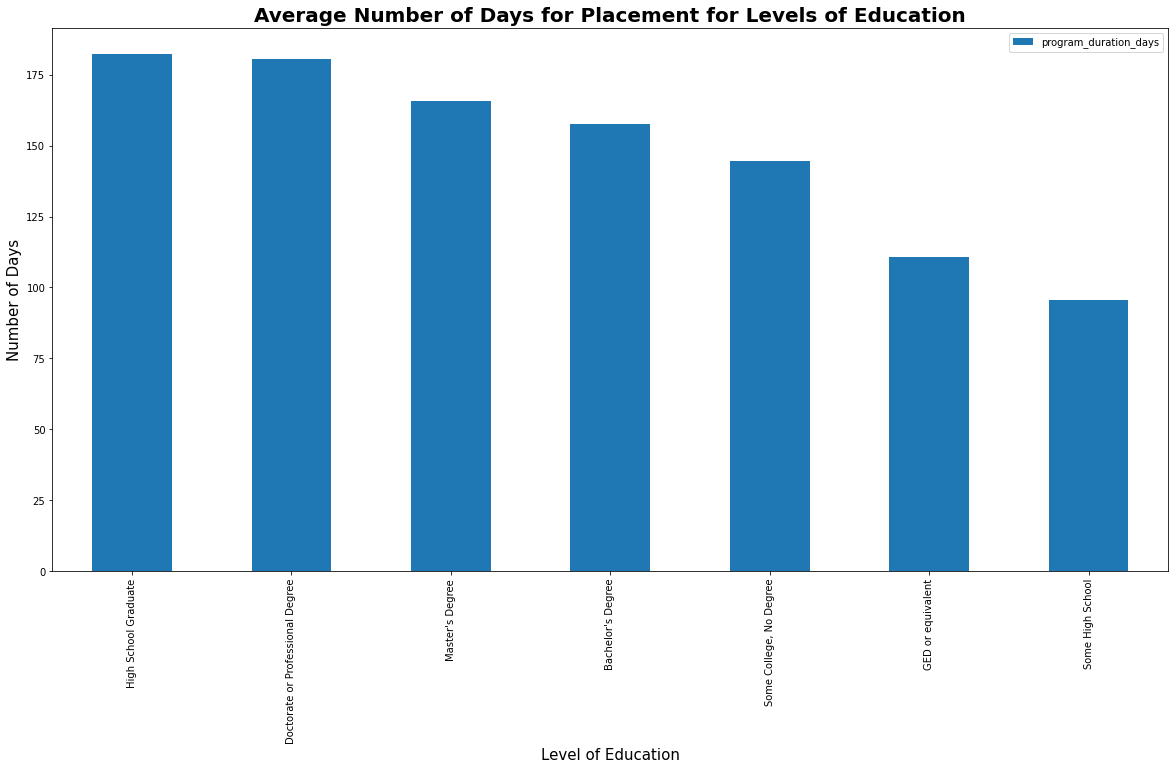

In [70]:
df_1 = df[df['placed'] == 1]
df_1.groupby('highest_level_of_education').agg({'program_duration_days':'mean'}).sort_values(by='program_duration_days', ascending=False).plot(kind='bar',figsize=(20,10))

plt.title ('Average Number of Days for Placement for Levels of Education', fontsize=20, fontweight="bold")
plt.xlabel("Level of Education", fontsize=15)
plt.ylabel("Number of Days", fontsize=15)
plt.show()

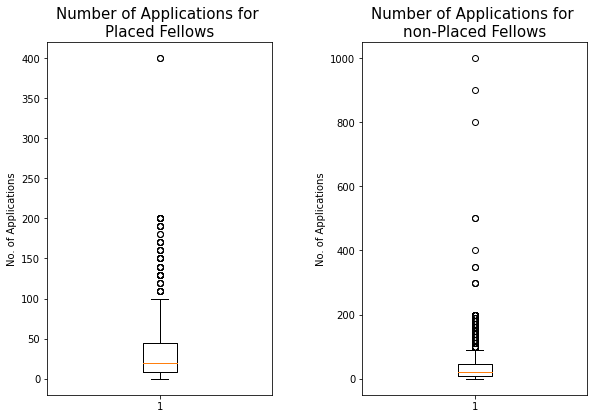

In [71]:
df_1 = df[df['placed'] == 1]
df_0 = df[df['placed'] == 0]

fig, ax = plt.subplots(1,2, figsize = (15, 7))
ax[0].set_title('Number of Applications for \nPlaced Fellows', fontsize = 15)
ax[0].boxplot(df_1['number_of_applications'])
ax[0].set_ylabel('No. of Applications')

ax[1].set_title('Number of Applications for \nnon-Placed Fellows', fontsize = 15)
ax[1].boxplot(df_0['number_of_applications'])
ax[1].set_ylabel('No. of Applications')

fig.subplots_adjust(left=0.25, bottom=0.15, right=0.75, top=0.85, wspace=0.4, hspace = 0.6)
plt.show()

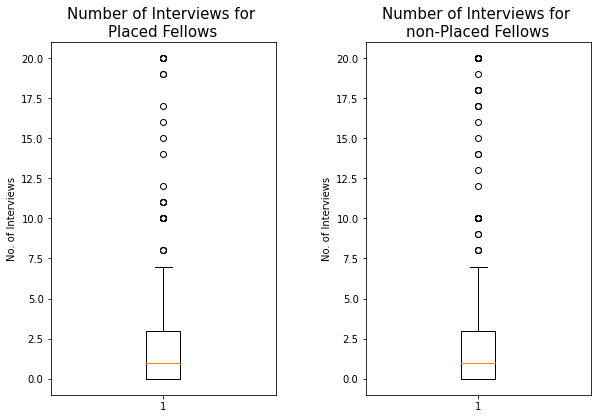

In [73]:
fig, ax = plt.subplots(1,2, figsize = (15, 7))
ax[0].set_title('Number of Interviews for \nPlaced Fellows', fontsize = 15)
ax[0].boxplot(df_1['number_of_interviews'].dropna())
ax[0].set_ylabel('No. of Interviews')

ax[1].set_title('Number of Interviews for \nnon-Placed Fellows', fontsize = 15)
ax[1].boxplot(df_0['number_of_interviews'].dropna())
ax[1].set_ylabel('No. of Interviews')

fig.subplots_adjust(left=0.25, bottom=0.15, right=0.75, top=0.85, wspace=0.4, hspace = 0.6)
plt.show()

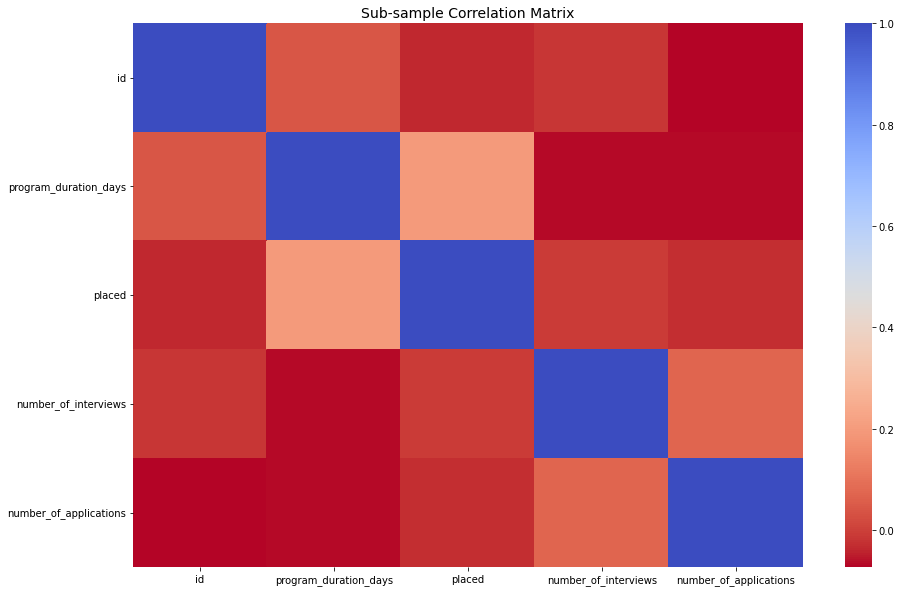

In [72]:
Plot(cust_success).corr()

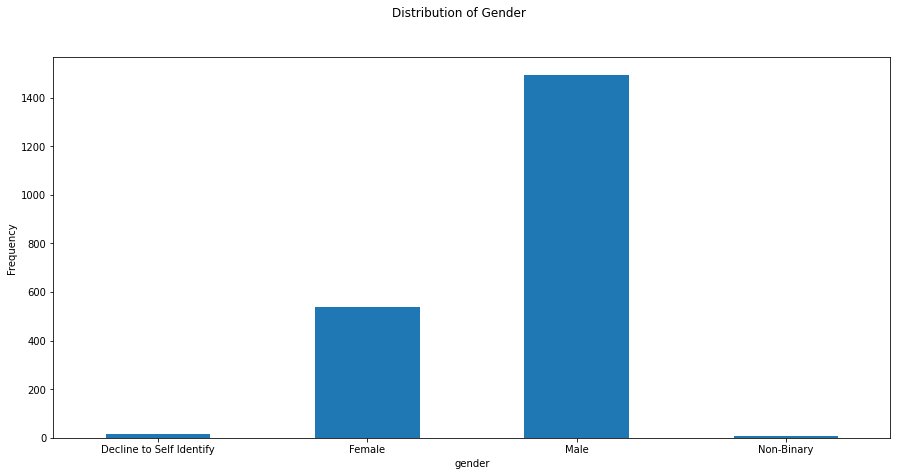

In [74]:
fig, ax = plt.subplots(figsize = (15, 7))
plt.suptitle('Distribution of Gender')
df.groupby('gender').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

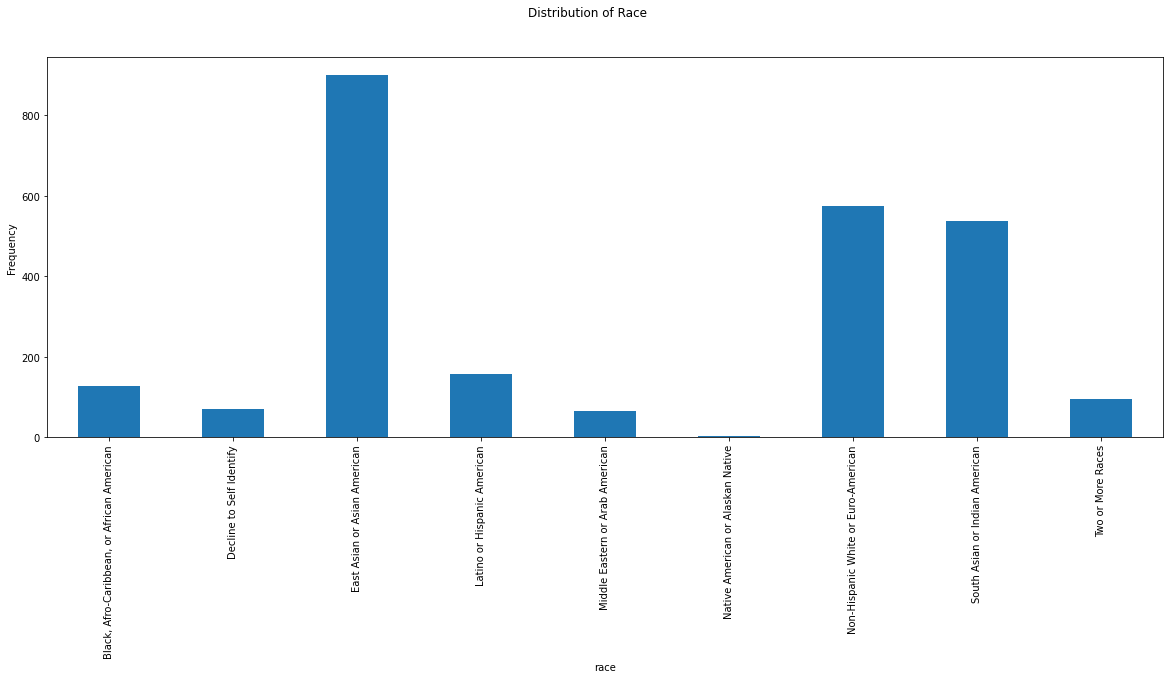

In [75]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Race')
df.groupby('race').size().to_frame().plot.bar(legend = False, ax = ax, rot = 90)
plt.ylabel('Frequency')
plt.show()

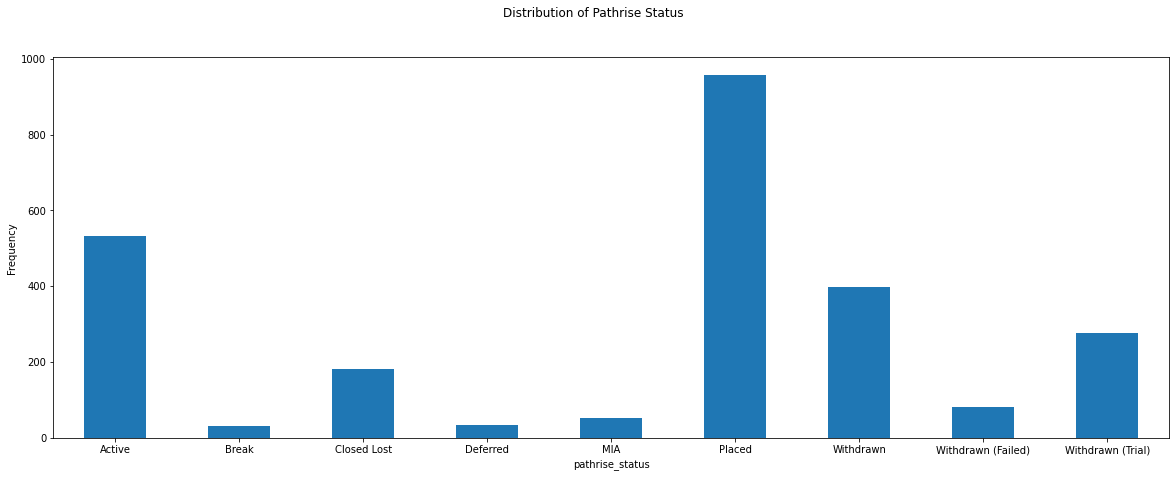

In [76]:

fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Pathrise Status')
df.groupby('pathrise_status').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

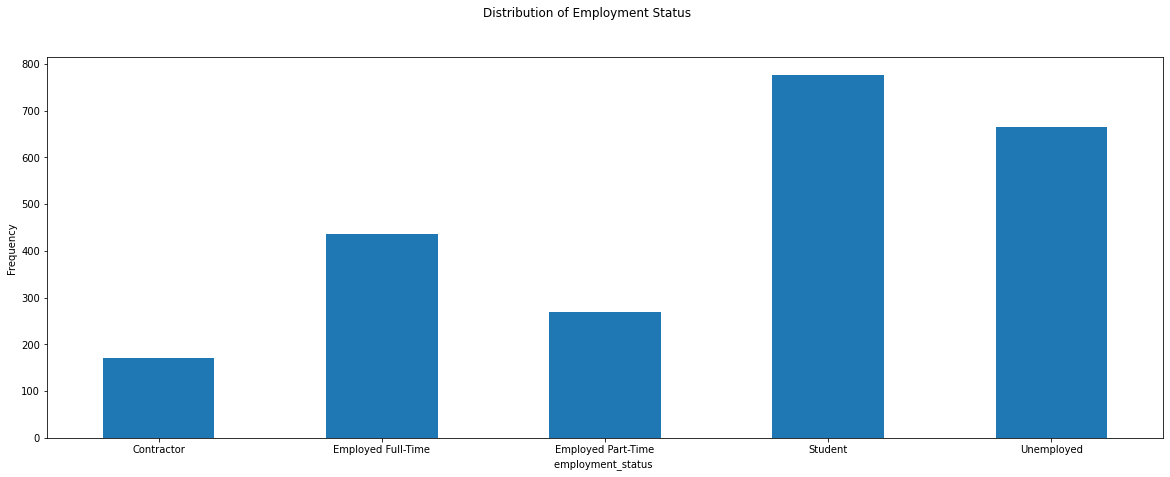

In [136]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Employment Status')
df.groupby('employment_status ').size().to_frame().plot.bar(legend = False, ax = ax, rot = 0)
plt.ylabel('Frequency')
plt.show()

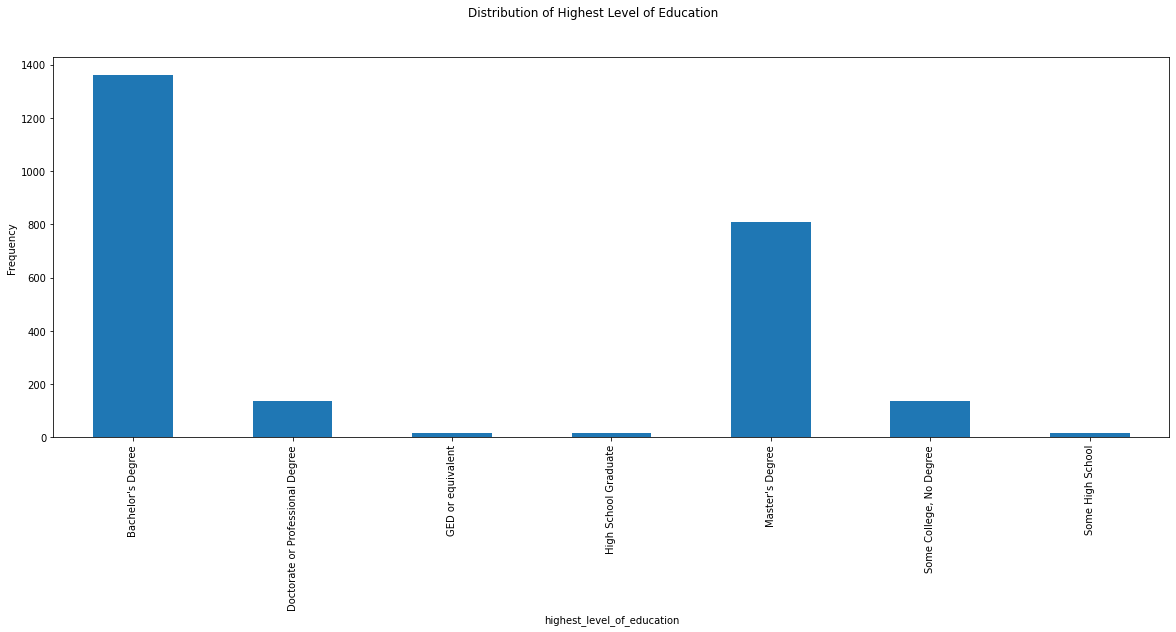

In [137]:
fig, ax = plt.subplots(figsize = (20, 7))
plt.suptitle('Distribution of Highest Level of Education')
df.groupby('highest_level_of_education').size().to_frame().plot.bar(legend = False, ax = ax, rot = 90)
plt.ylabel('Frequency')
plt.show()

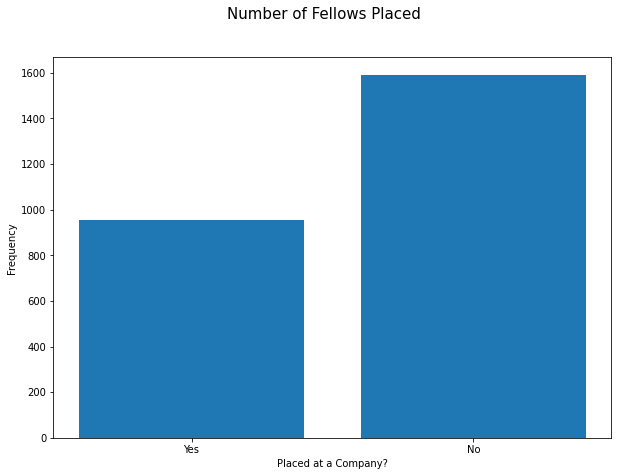

In [9]:
# Let's look at how many fellows placed at a company.

placed_df = pd.DataFrame({'Placed at a Company?': ['Yes', 'No'],'No. of Fellows': [df['placed'].sum(), df.shape[0] - df['placed'].sum()],})
placed_df.set_index('Placed at a Company?', inplace = True)

fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Fellows Placed', fontsize = 15)
plt.bar(x = placed_df.index, height = 'No. of Fellows', data = placed_df)
plt.xlabel('Placed at a Company?')
plt.ylabel('Frequency')
plt.show()

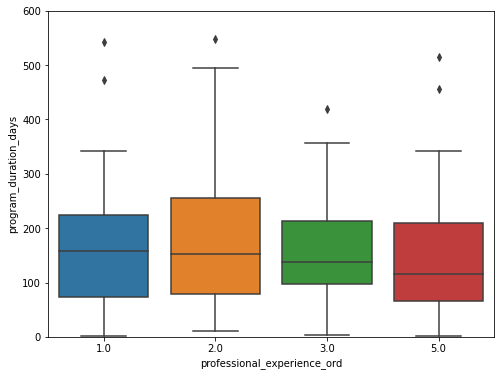

In [ ]:
# The most experienced gets placed faster.

var = 'professional_experience_ord'
data = pd.concat([cust_success_2_train['program_duration_days'], cust_success_2_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='program_duration_days', data=data)
fig.axis(ymin=0, ymax=600);

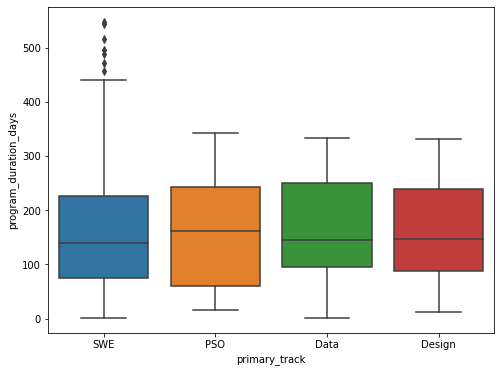

In [ ]:
# SWE has the lowest mean. Higher variance for PSO.

var = 'primary_track'
data = pd.concat([cust_success_2_train['program_duration_days'], cust_success_2_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='program_duration_days', data=data)


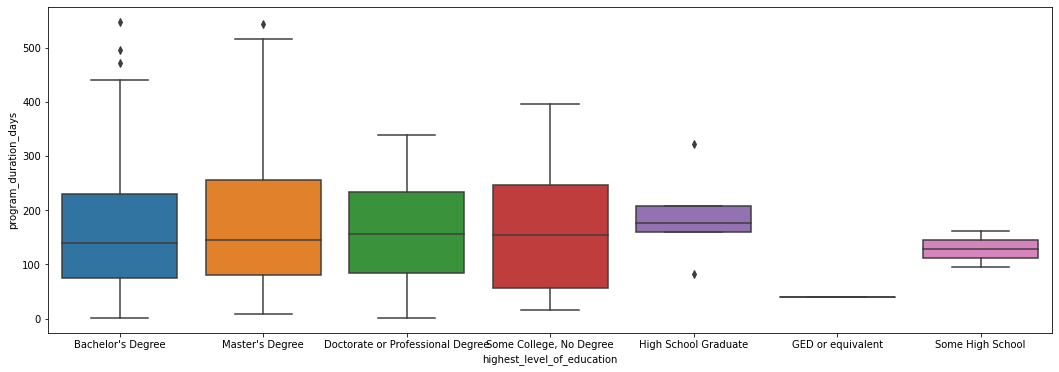

In [ ]:
# SWE has the lowest mean. Higher variance for PSO.

var = 'highest_level_of_education'
data = pd.concat([cust_success_2_train['program_duration_days'], cust_success_2_train[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=var, y='program_duration_days', data=data)


## Outlier removal for the continuous features

In [129]:
print(cust_success.shape)
cust_success=cust_success[cust_success['number_of_interviews']<7.5]
cust_success=cust_success[cust_success['number_of_applications']<200]
print(cust_success.shape)

(2544, 16)
(2231, 16)


## Scaling of the continuous variables

In [111]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# We will use Robust scaler because it's ideal if there are outliers

cust_success['number_of_interviews'] = rob_scaler.fit_transform(cust_success['number_of_interviews'].values.reshape(-1,1))
cust_success['number_of_applications'] = rob_scaler.fit_transform(cust_success['number_of_applications'].values.reshape(-1,1))

cust_success.describe()

,id,program_duration_days,placed,number_of_interviews,number_of_applications
count,2231.000000,1679.000000,2231.000000,2231.000000,2231.000000
mean,1284.423577,139.117332,0.377409,0.267145,0.344651
std,738.289901,125.908441,0.484847,0.641492,0.995447
min,2.000000,0.000000,0.000000,-0.333333,-0.555556
25%,645.500000,15.000000,0.000000,-0.333333,-0.305556
50%,1302.000000,116.000000,0.000000,0.000000,0.000000
75%,1924.500000,228.000000,1.000000,0.666667,0.694444
max,2544.000000,548.000000,1.000000,2.000000,4.722222


# Model building with dropped values

In the first approach of model building and prediction, we drop all the missing values to see how the prediction goes. 

In [12]:
df_test=cust_success[cust_success['pathrise_status']=='Active']
df=cust_success[cust_success['pathrise_status']!='Active']

ori_len=df.shape[0]
print(ori_len)

df=Drop_cat_na(df).drop_dat()
df_test=Drop_cat_na(df_test).drop_dat()

miss_len=df.shape[0]
print(miss_len)

print("We lose almost {0}% of data by dropping the missing values.".format(np.around((ori_len-miss_len)/ori_len*100)))

1749
969
We lose almost 45.0% of data by dropping the missing values.


### Filling the missing values in continuous variables and ordinal encoding

In [13]:
df.fillna(df.median(), inplace = True) # For the continuous values, Median is more meaningful than mean in Skewed data

df=Cat_encode(df).cat_encode()
df_test=Cat_encode(df_test).cat_encode()


### K-Means Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

X = df.drop(columns = ['placed','pathrise_status', 'id'])
y = df['placed']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=2, n_init=25, max_iter=100, random_state=6) # 2 clusters because it's binary classification
kmeans.fit(x_train)

pred = kmeans.predict(x_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.60      0.75      0.67        97
           1       0.67      0.49      0.57        97

    accuracy                           0.62       194
   macro avg       0.63      0.62      0.62       194
weighted avg       0.63      0.62      0.62       194



### Decision Tree Classifier

In [20]:
clf = DecisionTreeClassifier()

clf.fit(x_train, y_train)

pred = clf.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71        97
           1       0.71      0.70      0.70        97

    accuracy                           0.71       194
   macro avg       0.71      0.71      0.71       194
weighted avg       0.71      0.71      0.71       194



#### Hyper Parameter tuning for the decision tree

In [21]:
# Making a parameter grid using gridsearchcv

param_grid = {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 4, 6, 8, 10, 12],
              'min_samples_leaf': [1, 3, 5, 7, 9, 11],
              'max_leaf_nodes': [2, 5, 10, 20]}
              
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                  

In [22]:
pred = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.75        97
           1       0.72      0.96      0.82        97

    accuracy                           0.79       194
   macro avg       0.83      0.79      0.79       194
weighted avg       0.83      0.79      0.79       194



### Random Forest Classifier

In [23]:
clf = RandomForestClassifier(n_estimators=100)

clf.fit(x_train, y_train)

pred = clf.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.65      0.72        97
           1       0.71      0.86      0.78        97

    accuracy                           0.75       194
   macro avg       0.76      0.75      0.75       194
weighted avg       0.76      0.75      0.75       194



# Model building with imputed values for missing data

Instead of droppping 44% of the data, we can create a new feature value 'NA' for missing values in each categorical feature. 

In [130]:
df_test=cust_success[cust_success['pathrise_status']=='Active']
df=cust_success[cust_success['pathrise_status']!='Active']

ori_len=df.shape[0]
print(ori_len)

df=Imput_cat_na(df).imput_dat()
df_test=Imput_cat_na(df_test).imput_dat()

miss_len=df.shape[0]
print(miss_len)

print("We lose {0}% of data by dropping the missing values.".format(np.around((ori_len-miss_len)/ori_len*100)))


1749
1749
We lose 0.0% of data by dropping the missing values.


### Filling the missing values in continuous variables and ordinal encoding

In [113]:
df.fillna(df.median(), inplace = True) # For the continuous values, Median is more meaningful than mean in Skewed data
df_test.fillna(df_test.median(), inplace = True)

df=Cat_encode(df).cat_encode()
df_test=Cat_encode(df_test).cat_encode()


### Train-Test-Split

In [92]:
X = df.drop(columns = ['placed','pathrise_status', 'id'])
y = df['placed']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### K-Means Clustering

In [99]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

kmeans = KMeans(n_clusters=2, n_init=40, max_iter=300, random_state=20) # 2 clusters because it's binary classification
kmeans.fit(x_train)

pred = kmeans.predict(x_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.53      0.70      0.60       166
           1       0.62      0.45      0.52       184

    accuracy                           0.57       350
   macro avg       0.58      0.57      0.56       350
weighted avg       0.58      0.57      0.56       350



In [102]:
clf = DecisionTreeClassifier()

clf.fit(x_train, y_train)

pred = clf.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       166
           1       0.71      0.69      0.70       184

    accuracy                           0.69       350
   macro avg       0.69      0.69      0.69       350
weighted avg       0.69      0.69      0.69       350



## XGBoost

In [103]:
from xgboost import XGBClassifier

# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)

print(xgb_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [104]:
# make predictions for test data
y_pred = xgb_model.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       166
           1       0.75      0.89      0.82       184

    accuracy                           0.79       350
   macro avg       0.80      0.78      0.78       350
weighted avg       0.80      0.79      0.79       350



#### Hyper Parameter tuning for the XGBoost model

In [42]:
# Making a parameter grid using gridsearchcv

# max_depth=3, learning_rate=0.1, n_estimators=100
#objective='binary:logistic', booster='gbtree', n_jobs=1 gamma=0, 
# min_child_weight=1, max_delta_step=0,  base_score=0.5, random_state=0

param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [2, 3, 5],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
              
grid = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child

In [43]:
pred = grid.best_estimator_.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.64      0.75       166
           1       0.74      0.95      0.84       184

    accuracy                           0.80       350
   macro avg       0.83      0.79      0.79       350
weighted avg       0.83      0.80      0.80       350



# Dimensionality reduction using PCA

In [101]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA(n_components=5) #n_components=5
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

Accuracy (in %): 0.7035398230088495
F1 score 0.6824644549763034
(0.6728971962616822, 0.6923076923076923, 0.6824644549763034, None)


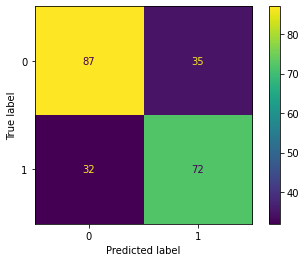

In [335]:
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

print("Accuracy (in %):", clf.score(x_test, y_test))

y_pred = clf.predict(x_test)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, x_test, y_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

plt.show()

# Logistic regression model

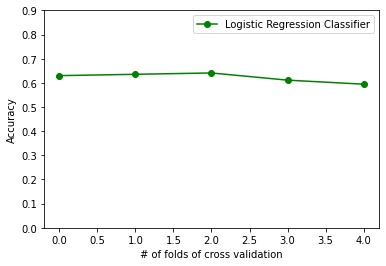

In [337]:
clf=LogisticRegression()
cv_score = cross_val_score(clf, 
                            x_train, y_train,
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = -1,
                            verbose = 0)

plt.plot(cv_score, 'go-',label='Logistic Regression Classifier')
plt.xlabel('# of folds of cross validation')
plt.ylabel('Accuracy')
plt.ylim(0,0.9)
plt.legend()
plt.show()

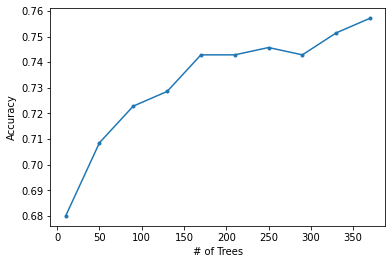

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accu=[]
for i in np.arange(10, 400, 40):
  classifier = RandomForestClassifier(n_estimators=i, random_state=0)
  classifier.fit(x_train, y_train)
  y_pred = classifier.predict(x_test)
  accu.append(accuracy_score(y_test, y_pred))

plt.plot(np.arange(10, 400, 40), accu, '.-')
plt.xlabel('# of Trees')
plt.ylabel('Accuracy')
plt.show()

# How fast do fellows get placed?

In [176]:
# Loading the data
cust_success=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Pathrise/Data_Pathrise.xlsx')

## Outlier removal for the continuous features

In [177]:
print(cust_success.shape)
cust_success=cust_success[cust_success['number_of_interviews']<7.5]
cust_success=cust_success[cust_success['number_of_applications']<200]
print(cust_success.shape)

(2544, 16)
(2231, 16)


## Scaling of the continuous variables

In [178]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# We will use Robust scaler because it's ideal if there are outliers

cust_success['number_of_interviews'] = rob_scaler.fit_transform(cust_success['number_of_interviews'].values.reshape(-1,1))
cust_success['number_of_applications'] = rob_scaler.fit_transform(cust_success['number_of_applications'].values.reshape(-1,1))

cust_success.describe()

,id,program_duration_days,placed,number_of_interviews,number_of_applications
count,2231.000000,1679.000000,2231.000000,2231.000000,2231.000000
mean,1284.423577,139.117332,0.377409,0.267145,0.344651
std,738.289901,125.908441,0.484847,0.641492,0.995447
min,2.000000,0.000000,0.000000,-0.333333,-0.555556
25%,645.500000,15.000000,0.000000,-0.333333,-0.305556
50%,1302.000000,116.000000,0.000000,0.000000,0.000000
75%,1924.500000,228.000000,1.000000,0.666667,0.694444
max,2544.000000,548.000000,1.000000,2.000000,4.722222


## Model building with imputed values for missing data

Instead of droppping 44% of the data, we can create a new feature value 'NA' for missing values in each categorical feature. 

In [179]:
df_test=cust_success[cust_success['pathrise_status']=='Active']
df=cust_success[cust_success['pathrise_status']!='Active']

ori_len=df.shape[0]
print(ori_len)

df=Imput_cat_na(df).imput_dat()
df_test=Imput_cat_na(df_test).imput_dat()

miss_len=df.shape[0]
print(miss_len)

print("We lose {0}% of data by dropping the missing values.".format(np.around((ori_len-miss_len)/ori_len*100)))


1749
1749
We lose 0.0% of data by dropping the missing values.


In [180]:
# df.fillna(df.median(), inplace = True) # For the continuous values, Median is more meaningful than mean in Skewed data
df.fillna(0, inplace = True) # For the continuous values, Median is more meaningful than mean in Skewed data

# df_test.fillna(df_test.median(), inplace = True)
df_test.fillna(0, inplace = True)

df=Cat_encode(df).cat_encode()
df_test=Cat_encode(df_test).cat_encode()


In [181]:
df=df[df.placed==1].drop(['placed','id','pathrise_status'], axis=1)

TARGET='program_duration_days'
features=[i for i in list(df.columns) if i!=TARGET]

X=df[features]
y=df[TARGET]

X.head()

,primary_track,cohort_tag,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
23,2.0,37.0,5.0,4.0,2.0,5.0,0.0,1.0,1.333333,-0.444444,2.0,7.0
30,3.0,36.0,4.0,4.0,3.0,1.0,0.0,2.0,-0.333333,-0.527778,2.0,2.0
54,3.0,6.0,4.0,4.0,3.0,2.0,1.0,3.0,-0.333333,0.277778,1.0,2.0
63,3.0,45.0,5.0,0.0,0.0,4.0,0.0,3.0,-0.333333,-0.555556,1.0,0.0
64,0.0,39.0,4.0,0.0,1.0,5.0,0.0,1.0,0.000000,1.388889,2.0,8.0


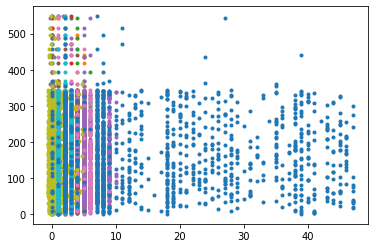

In [182]:
for i in X.columns[1:]:
  plt.plot(X[i], y, '.')

## Training and testing data 

In [183]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear regression model

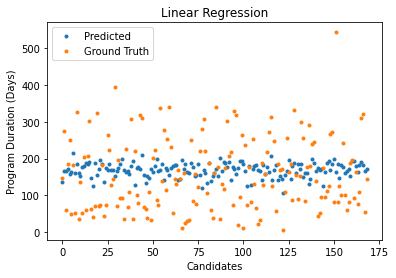

0.030770345957757624


In [184]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

plt.plot(np.array(y_pred),'.', label='Predicted')
plt.plot(np.array(y_test),'.', label='Ground Truth')
plt.xlabel('Candidates')
plt.ylabel('Program Duration (Days)')
plt.title('Linear Regression')
plt.legend()
# plt.ylim(0,400)
plt.show()

print(reg.score(x_train, y_train))

In [ ]:
# Stratified K-fold cross-validation code

features = list(train_df.columns[1:101])

train_oof = np.zeros((250000,))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df[features], train_df['loss'])):
    X_train, X_valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    y_train = X_train['loss']
    y_valid = X_valid['loss']
    X_train = X_train.drop('loss', axis=1)
    X_valid = X_valid.drop('loss', axis=1)
    
    model = LinearRegression()

    model =  model.fit(X_train, y_train)
    temp_oof = model.predict(X_valid)
    train_oof[valid_idx] = temp_oof
    print(f'Fold {fold} RMSE: ', mean_squared_error(y_valid, temp_oof, squared=False))
    
print(f'OOF Accuracy: ', mean_squared_error(train_df['loss'], train_oof, squared=False))


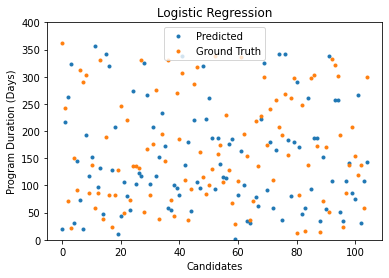

0.8357142857142857


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=500).fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)

plt.plot(np.array(y_pred2),'.', label='Predicted')
plt.plot(np.array(y_test2),'.', label='Ground Truth')
plt.xlabel('Candidates')
plt.ylabel('Program Duration (Days)')
plt.title('Logistic Regression')
plt.legend()
plt.ylim(0,400)
plt.show()

print(clf.score(X_train2, y_train2))

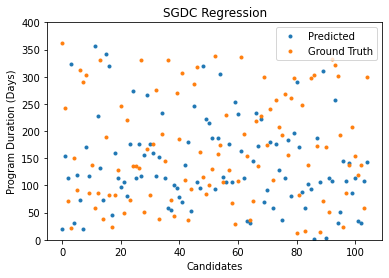

0.7333333333333333


In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train2, y_train2)

y_pred2=clf.predict((X_test2))

plt.plot(np.array(y_pred2),'.', label='Predicted')
plt.plot(np.array(y_test2),'.', label='Ground Truth')
plt.xlabel('Candidates')
plt.ylabel('Program Duration (Days)')
plt.title('SGDC Regression')
plt.legend()
plt.ylim(0,400)
plt.show()

print(clf.score(X_train2, y_train2))